# Stage 09 — Homework Starter Notebook

In the lecture, we learned how to create engineered features. Now it’s your turn to apply those ideas to your own project data.

In [8]:
import pandas as pd
import numpy as np

# Example synthetic data (replace with your project dataset)
np.random.seed(0)
n = 100
df = pd.DataFrame({
    'income': np.random.normal(60000, 15000, n).astype(int),
    'monthly_spend': np.random.normal(2000, 600, n).astype(int),
    'credit_score': np.random.normal(680, 50, n).astype(int)
})
df.head()

,income,monthly_spend,credit_score
0,86460,3129,661
1,66002,1191,668
2,74681,1237,734
3,93613,2581,712
4,88013,1296,712


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import os

# Set plotting style
sns.set(context='talk', style='whitegrid')
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# --- Replaced with my project datasets ---
# Assuming the acquire script has been run and data is saved in ../data/raw
RAW_DATA_PATH = pathlib.Path('../data/raw')

# 1. Load the latest API (AAPL stock) data file
api_files = sorted(list(RAW_DATA_PATH.glob('api_aapl.csv')), reverse=True)
if not api_files:
    raise FileNotFoundError("No AAPL API data files found in ../data/raw. Please run the data acquisition script first.")


latest_api_file = api_files[0]
print(f"Loading AAPL stock data from: {latest_api_file}")

df = pd.read_csv(latest_api_file)

# Convert 'date' to datetime and set as index for time series features
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').set_index('date')

# Ensure numeric types for relevant columns
for col in ['open', 'high', 'low', 'close', 'volume']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop any rows with NaN in critical columns after numeric conversion
df.dropna(subset=['open', 'high', 'low', 'close', 'volume'], inplace=True)

df.head()

Loading AAPL stock data from: ../data/raw/api_aapl.csv


,open,high,low,close,volume
date,,,,,
1999-11-01,80.00,80.69,77.37,77.62,2487300
1999-11-02,78.00,81.69,77.31,80.25,3564600
1999-11-03,81.62,83.25,81.00,81.50,2932700
1999-11-04,82.06,85.37,80.62,83.62,3384700
1999-11-05,84.62,88.37,84.00,88.31,3721500


## TODO: Implement at least 2 engineered features here

In [10]:
# Feature 1: Daily Return
# Calculate the percentage change in the closing price
df['daily_return'] = df['close'].pct_change()

# Feature 2: Rolling 5-day Moving Average of Close Price
# Captures the short-term trend in the stock price
df['rolling_avg_5d_close'] = df['close'].rolling(window=5).mean()

# Feature 3: Rolling 5-day Volatility (Standard Deviation of Daily Returns)
# Measures the price fluctuation over a short period
df['rolling_vol_5d'] = df['daily_return'].rolling(window=5).std()

df.head(10) # Display first few rows with new features

,open,high,low,close,volume,daily_return,rolling_avg_5d_close,rolling_vol_5d
date,,,,,,,,
1999-11-01,80.00,80.69,77.37,77.62,2487300,NaN,NaN,NaN
1999-11-02,78.00,81.69,77.31,80.25,3564600,0.033883,NaN,NaN
1999-11-03,81.62,83.25,81.00,81.50,2932700,0.015576,NaN,NaN
1999-11-04,82.06,85.37,80.62,83.62,3384700,0.026012,NaN,NaN
1999-11-05,84.62,88.37,84.00,88.31,3721500,0.056087,82.260,NaN
1999-11-08,87.75,97.73,86.75,96.37,8490400,0.091269,86.010,0.030053
1999-11-09,94.37,94.50,88.00,89.62,7224800,-0.070043,87.884,0.060153
1999-11-10,88.25,93.25,88.12,91.44,5159800,0.020308,89.872,0.060029
1999-11-11,91.59,92.62,89.87,92.25,2409600,0.008858,91.598,0.060426


### Rationale for Feature 1: Daily Return

**Feature Name:** `daily_return`

**Rationale:**
Daily return is a fundamental metric in financial analysis, representing the percentage change in a stock's price from one day to the next.

It directly quantifies price movement and is often the primary target variable in forecasting tasks (e.g., predicting future returns) or a strong predictor for other financial events. By normalizing price changes, it makes different stocks or time periods comparable. Models can use this feature to capture the immediate past performance of the stock.

Understanding the distribution, volatility, and historical patterns of daily returns is a core part of financial exploratory data analysis. This feature provides a direct numerical representation of this key financial dynamic.

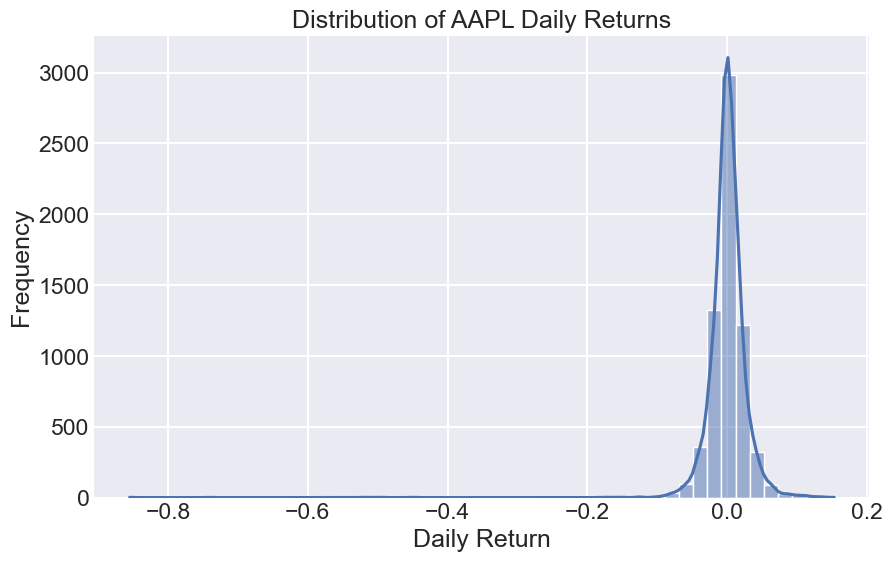


Daily Return Statistics:
count    6489.000000
mean        0.000788
std         0.029419
min        -0.854857
25%        -0.009971
50%         0.000891
75%         0.012685
max         0.153288
Name: daily_return, dtype: float64
-0.4584722846162982


In [12]:
# Feature 1: Distribution of Daily Returns and its basic statistics
plt.figure(figsize=(10, 6))
sns.histplot(df['daily_return'].dropna(), kde=True, bins=50)
plt.title('Distribution of AAPL Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()

print("\nDaily Return Statistics:")
print(df['daily_return'].describe())

df['abs_daily_price_change'] = (df['close'] - df['close'].shift(1)).abs()

correlation_value = df[['daily_return', 'abs_daily_price_change']].corr().iloc[0, 1]

print(correlation_value)

### Rationale for Feature 2: Rolling 5-day Moving Average of Close Price

**Feature Name:** `rolling_avg_5d_close`

**Rationale:**
The 5-day rolling moving average smooths out short-term price fluctuations to highlight the underlying trend in the stock price. It represents the average closing price over the past five trading days.

Moving averages are widely used by traders and investors to identify trends (e.g., an upward trend if the current price is consistently above its moving average) and potential support or resistance levels. Incorporating this feature allows a model to capture short-term momentum or trend signals that raw daily prices might obscure, providing a clearer picture of recent price action.

Visualizing the stock price over time alongside its moving average is a common EDA technique in finance to spot trends. This feature operationalizes that visual insight into a quantifiable variable.

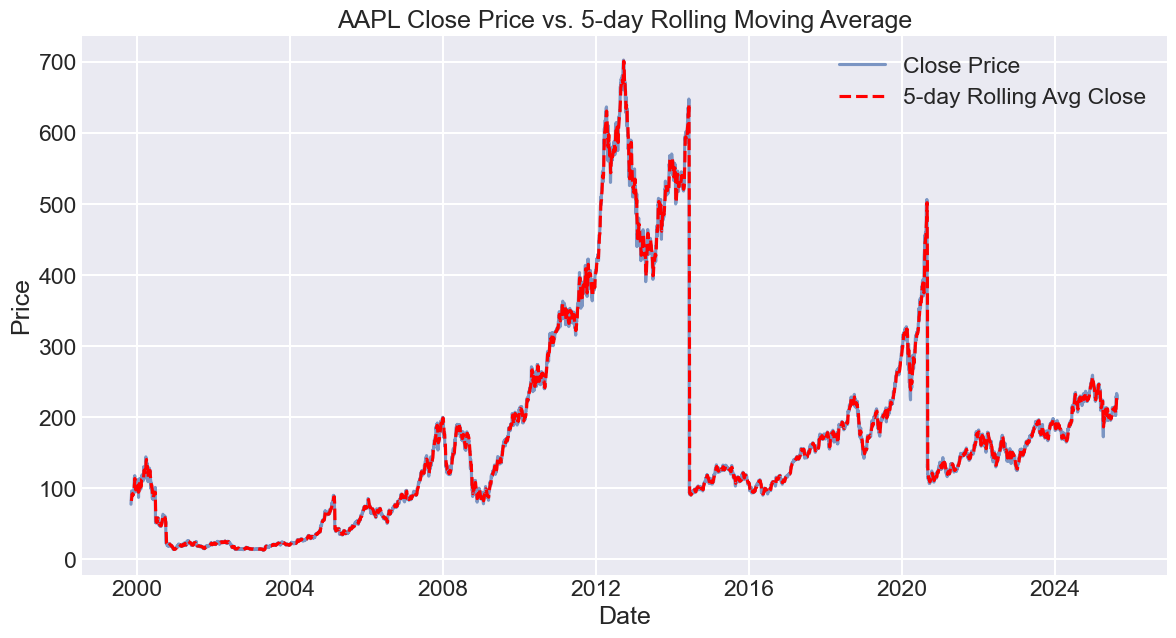


Correlation of Close Price with 5-day Rolling Average:
0.997521036778702


In [ ]:
# Check for Feature 2: Visualization of Rolling Moving Average against Close Price
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['close'], label='Close Price', alpha=0.7)
plt.plot(df.index, df['rolling_avg_5d_close'], label='5-day Rolling Avg Close', color='red', linestyle='--')
plt.title('AAPL Close Price vs. 5-day Rolling Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Check correlation between close price and its rolling average (expected to be high)
print("\nCorrelation of Close Price with 5-day Rolling Average:")
print(df[['close', 'rolling_avg_5d_close']].corr().iloc[0,1])

### Rationale for Feature 3: Rolling 5-day Volatility (Standard Deviation of Daily Returns)

**Feature Name:** `rolling_vol_5d`

**Rationale:**
Volatility measures the degree of variation of a trading price series over time. High volatility means the price can change dramatically over a short period, while low volatility means the price is relatively stable. Using the rolling standard deviation of daily returns provides a dynamic, short-term measure of market risk and price fluctuation.

Models predicting risk, option pricing, or even future price movements (as periods of high volatility often precede large price swings) can benefit significantly from this feature. It helps the model understand the "choppiness" or stability of the stock's recent performance, which is crucial for making informed predictions.

In financial EDA, examining periods of high and low volatility, and how they correlate with other market events or returns, is crucial. This feature directly quantifies that aspect for a specific rolling window.

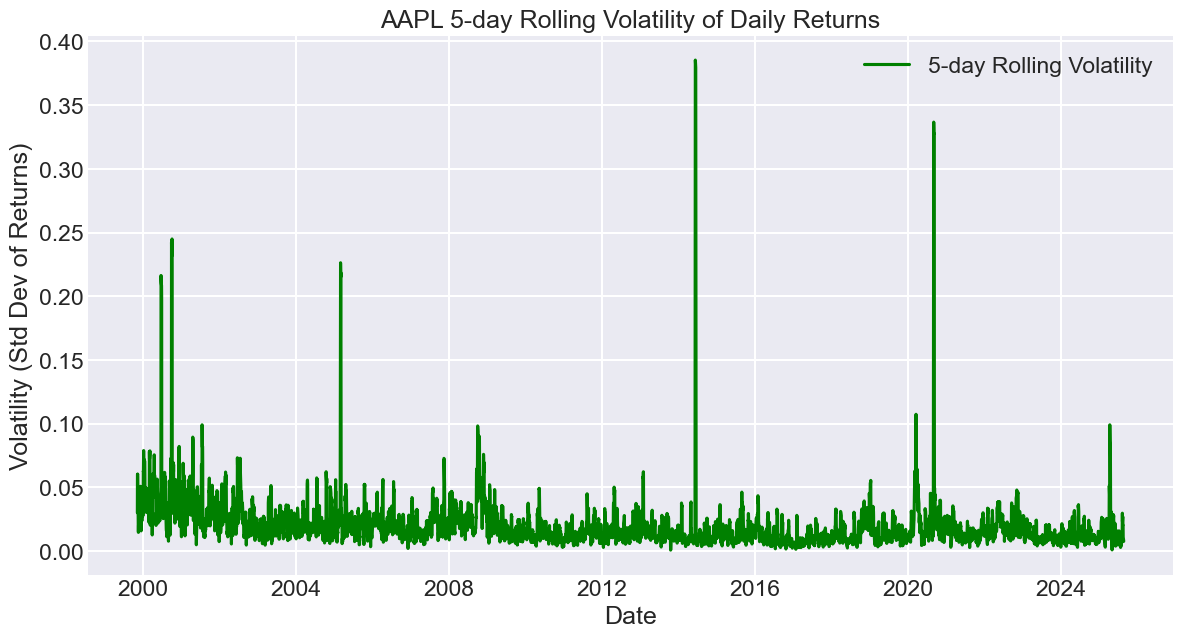


5-day Rolling Volatility Statistics:
count    6485.000000
mean        0.020746
std         0.021084
min         0.000753
25%         0.010675
50%         0.016160
75%         0.025259
max         0.385349
Name: rolling_vol_5d, dtype: float64

Correlation of Rolling Volatility with Absolute Daily Return:
0.5282662184958359


In [15]:
# Check for Feature 3: Visualization of Rolling Volatility
plt.figure(figsize=(14, 7))
volatility_data = df['rolling_vol_5d'].dropna()
plt.plot(volatility_data.index, volatility_data, label='5-day Rolling Volatility', color='green')
plt.title('AAPL 5-day Rolling Volatility of Daily Returns')
plt.xlabel('Date')
plt.ylabel('Volatility (Std Dev of Returns)')
plt.legend()
plt.grid(True)
plt.show()

print("\n5-day Rolling Volatility Statistics:")
print(df['rolling_vol_5d'].describe())

# Check for Feature 3: Correlation of Volatility with Absolute Daily Return
# High volatility might be associated with larger (positive or negative) daily returns
print("\nCorrelation of Rolling Volatility with Absolute Daily Return:")
common_dates_for_corr = df['daily_return'].dropna().index.intersection(df['rolling_vol_5d'].dropna().index)
df_aligned = df.loc[common_dates_for_corr].copy()

# Calculate the absolute daily return and assign it to a new temporary column in df_aligned
df_aligned['abs_daily_return'] = df_aligned['daily_return'].abs()

# Now perform the correlation using the string column names
correlation_value = df_aligned[['rolling_vol_5d', 'abs_daily_return']].corr().iloc[0,1]

print(correlation_value)
